## Imports and Installations

In [1]:
import random
# Set a seed for the random number generator to ensure reproducibility
random.seed(42)

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.8 MB/s eta 0:00:00


In [3]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
import random
filterwarnings('ignore')


# DATASET

In [5]:
# Set various display options for pandas DataFrame
# This line sets the maximum number of columns displayed in the output to be unlimited
pd.set_option('display.max_columns', None)

# This line sets the maximum number of rows displayed in the output to be unlimited
pd.set_option('display.max_rows', None)

# This line sets the floating-point format for the display. Here, it's set to show three decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# This line sets the total width of the display in characters to 500
pd.set_option('display.width', 500)

# Reading a CSV file containing diabetes data and storing it in a DataFrame
diabetes = pd.read_csv("./Dataset/diabetes.csv")

# Creating a copy of the DataFrame to work on, so the original data remains unchanged
df = diabetes.copy()

# Displaying the first few rows of the DataFrame
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# DATA PRE-PROCESSING

In [6]:
# Let's make variables's names smaller
df.columns = [col.lower() for col in df.columns]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

   Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
   Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables

        The sum of 3 lists with return equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [9]:
# Outliers

def outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85):
    '''
    This function calculates the lower and upper thresholds for outliers in a given column of a dataframe.
    It uses the interquartile range method where outliers are defined as observations that fall below Q1 - 1.5*IQR
    or above Q3 + 1.5*IQR. The quartiles can be adjusted with q1 and q3 parameters.

    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - col_name: The name of the column for which to calculate outlier thresholds.
    - q1: The lower quartile value (default is 0.15).
    - q3: The upper quartile value (default is 0.85).

    Returns:
    - low_limit: The lower threshold value for outliers.
    - up_limit: The upper threshold value for outliers.
    '''
    quartile1 = dataframe[col_name].quantile(q1)  # Calculate the first quartile
    quartile3 = dataframe[col_name].quantile(q3)  # Calculate the third quartile
    interquantile_range = quartile3 - quartile1   # Calculate the interquartile range (IQR)
    up_limit = quartile3 + interquantile_range    # Define the upper limit for outliers
    low_limit = quartile1 - 1.3 * interquantile_range  # Define the lower limit for outliers
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
  '''
  This function checks if there are any outliers in a specific column of the dataframe.
  It uses the outlier thresholds defined in the outlier_thresholds function.

  Parameters:
  - dataframe: The pandas DataFrame containing the data.
  - col_name: The name of the column to check for outliers.

  Returns:
  - A boolean value: True if there are outliers in the column, False otherwise.
  '''
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)  # Get the lower and upper thresholds for outliers
  # Check if there are any values outside the outlier thresholds and return True if outliers are present
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
      return True
  else:
      return False

In [10]:
# def grab_outliers(dataframe, col_name, index=False):
#     '''
#     This function identifies and prints the outliers in a specific column of a dataframe.
#     It first determines the lower and upper outlier thresholds using the outlier_thresholds function.
#     If there are more than 10 outliers, it prints the first 5 of them; otherwise, it prints all the outliers.

#     Parameters:
#     - dataframe: The pandas DataFrame containing the data.
#     - col_name: The name of the column to check for outliers.
#     - index: A boolean flag to determine if the function should return the indices of the outliers (default is False).

#     Returns:
#     - If index is True, returns the indices of the outliers in the column.
#     '''
#     low, up = outlier_thresholds(dataframe, col_name)  # Get the lower and upper thresholds for outliers
#     # Check if there are outliers and print them
#     if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
#         # If there are more than 10 outliers, print the first 5
#         print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
#     else:
#         # If there are 10 or fewer outliers, print them all
#         print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

#     # If index flag is set to True, return the indices of the outliers
#     if index:
#         outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
#         return outlier_index

# # Loop through each column in the dataframe and apply the grab_outliers function
# for col in df.columns:
#   print(col, grab_outliers(df, col))

In [11]:
def replace_with_thresholds(dataframe, variable):
    '''
    This function replaces the outliers in a specified column of a dataframe with the outlier thresholds.
    It first calculates the lower and upper thresholds for outliers in the column using the outlier_thresholds function.
    Then, it replaces values in the column that are below the lower limit with the lower limit,
    and values that are above the upper limit with the upper limit.

    Parameters:
    - dataframe: The pandas DataFrame containing the data.
    - variable: The name of the column in which to replace outliers.

    Returns:
    - None: The function modifies the dataframe in place.
    '''
    low_limit, up_limit = outlier_thresholds(dataframe, variable)  # Determine the low and up limits for the outliers

    # Replace values below the lower limit with the lower limit
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit

    # Replace values above the upper limit with the upper limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Assuming num_cols is a list of column names that are numerical
for col in num_cols:
    # Apply the replace_with_thresholds function to each numerical column in the dataframe
    replace_with_thresholds(df, col)


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.000,3.842,3.360,0.000,1.000,3.000,6.000,15.000
glucose,768.000,120.937,31.816,6.500,99.000,117.000,140.250,199.000
bloodpressure,768.000,70.188,15.673,24.200,62.000,72.000,80.000,110.000
skinthickness,768.000,20.504,15.817,0.000,0.000,23.000,32.000,74.000
insulin,768.000,75.132,97.656,0.000,0.000,30.500,127.250,359.800
bmi,768.000,32.047,7.454,5.968,27.300,32.000,36.600,53.785
diabetespedigreefunction,768.000,0.463,0.296,0.078,0.244,0.372,0.626,1.321
age,768.000,33.224,11.700,21.000,24.000,29.000,41.000,70.000
outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [13]:
# There are no missing observations in the dataset
# but for variables such as Glucose, Insulin, etc., observation units containing a value of 0 may represent a missing value.
variables = ["skinthickness", "insulin"]
df[variables] = df[variables].replace(0,np.NaN)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                     374
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [14]:
# Handle to missing value
# df["skinthickness"].fillna(df.groupby("outcome")["skinthickness"].transform("mean"), inplace=True)
df["insulin"].fillna(df.groupby('outcome')["insulin"].transform("mean"), inplace=True)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                       0
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

## Feature Engineering


In [15]:
# retaining features which the user can alter by making life changes
df = df[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction','outcome']]

In [16]:
num_cols.remove('pregnancies')
num_cols.remove('skinthickness')
num_cols.remove('age')

In [17]:
# Now time to future scaling for numeric cols
rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])
df.head()

,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,outcome
0,0.752,0.000,0.946,0.172,0.665,1
1,-0.776,-0.333,0.000,-0.581,-0.056,0
2,1.600,-0.444,0.946,-0.935,0.783,1
3,-0.679,-0.333,-0.457,-0.419,-0.537,0
4,0.485,-1.778,0.628,1.194,2.480,1


In [18]:
#Testing inverse scaler**
newdf = df.copy()
newdf[num_cols] = rs.inverse_transform(df[num_cols])
newdf.head()

,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,outcome
0,148.000,72.000,189.692,33.600,0.627,1
1,85.000,66.000,125.155,26.600,0.351,0
2,183.000,64.000,189.692,23.300,0.672,1
3,89.000,66.000,94.000,28.100,0.167,0
4,137.000,40.000,168.000,43.100,1.321,1


## PREDICTION

We experimented with a bunch of models and corresponding hyper-parameter tuning and retained the most important features

### Light GBM

In [19]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)


lgbm = LGBMClassifier(learning_rate=0.01, max_depth=3, subsample=0.6, n_estimators=1000, min_child_samples=10)
lgbm_model = lgbm.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

0.8701298701298701

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        99
           1       0.83      0.80      0.81        55

    accuracy                           0.87       154
   macro avg       0.86      0.85      0.86       154
weighted avg       0.87      0.87      0.87       154



## Getting SHAPley Values

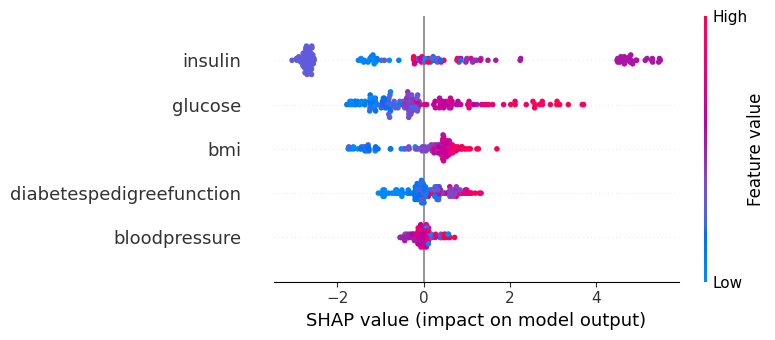

In [21]:
import shap
explainer = shap.TreeExplainer(lgbm_model, X_train)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Create a summary plot for feature importance across all predictions
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [22]:
# Create a DataFrame with SHAP values and 'ID' as a separate column
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

shap_df['ID'] = [i for i in range(1, len(X_test)+1)]
class_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
predicted_labels = lgbm_model.predict(X_test)
shap_df['prediction'] = predicted_labels
shap_df['class_prob'] = class_probabilities

In [23]:
shap_df.head()

,glucose,bloodpressure,insulin,bmi,diabetespedigreefunction,ID,prediction,class_prob
0,-0.775,-0.533,2.252,0.557,-0.002,1,0,0.441
1,-0.403,0.026,-2.698,0.462,-0.925,2,0,0.005
2,-0.397,0.005,-2.778,0.243,-0.941,3,0,0.004
3,-0.184,0.063,-2.717,-1.361,1.004,4,0,0.007
4,0.798,0.507,-2.797,0.323,0.057,5,0,0.055


In [24]:
X_test['outcome'] = y_test
X_test_n = X_test.copy()
X_test_n[num_cols] = rs.inverse_transform(X_test[num_cols])

In [25]:
X_test_n['ID'] = [i for i in range(1, len(X_test)+1)]

In [26]:
# Set a fixed seed for reproducibility


'''
Select 25 examples with even distribution of classes
'''
random_state = 42

# Separate examples by class
class_0_examples = X_test_n[X_test_n['outcome'] == 0]
class_1_examples = X_test_n[X_test_n['outcome'] == 1]

# Select 13 examples labeled as '1' and 12 examples labeled as '0'
X_test_llm = pd.concat([class_0_examples.sample(12, random_state=random_state),
                        class_1_examples.sample(13, random_state=random_state)])

# The random_state parameter ensures consistent sampling


In [27]:
shap_df_llm = shap_df[shap_df['ID'].isin(X_test_llm['ID'])]

## Prompt Engineering and Automating Prompt Generation

In [28]:
def getPrompts():
  prompt1 = """Hey buddy,
We want to use natural text to query a machine-learning medical model directly, bridging the gap between complex algorithmic processes and patient comprehensibility.
We have trained a machine learning model to predict the likelihood of the person getting diagnosed with diabetes when given a patient's vital feature data.
Given the feature list and the corresponding SHAP values for that patient, I want you to translate a simple, human-understandable explanation of how the model works, and, in case of the question request lifestyle suggestion, I want you to suggest changes to the two most important features to increase the likelihood of the person surviving.


Here is the feature list:
['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']

Here is the model prediction probability (0: No Diabetes, 1: Diabetes): """

  # prob = 0.1 # fill actual values

  prompt2 = """\n\nHere are this test subjects corresponding feature values: """

  # feature_values = [21,4,3,425,43,2]

  prompt3 = """\n\nAnd here are the corresponding SHAP values for that particular patient/record in the test set: """

  # shap_values = [2332,342,4,36,3,654,76,47]

  prompt4 = """\n\nThe Question:\n"""

  # ques = "what can I as a patient focus on to reduce my risk rate?"

  prompt5="\n\nYour Answer in no more than 250 words :\n"

  prompt6="\nYou are trying to explain it to a patient who does not have a machine learning experience and what SHAP values mean.\n"

  return prompt1, prompt2, prompt3, prompt4, prompt5,prompt6

In [29]:
def generate_final_prompt(prob, features_values, shap_values, ques):

    prompt1, prompt2, prompt3, prompt4, prompt5, prompt6 = getPrompts()
    prompt = prompt1 + str(prob) + prompt2 + str(features_values) + prompt3 + str(shap_values) + prompt4 + str(ques) + prompt5 + prompt6

    return prompt

In [35]:
'''Question of High Risk Score Patients'''
question_list_high_risk = ["Why is the risk score so high?",\
                           "What could be done to lower the risk score?",\
                           "How would a change in BMI (or/and, 'glucose', 'bloodpressure', 'insulin', 'diabetespedigreefunction') affect this risk score?"]

In [36]:
'''Question of Low Risk Score Patients'''

question_list_low_risk = ["What factors contributed to my low risk of diabetes?",\
                          "Are there specific lifestyle changes I can make to maintain this low risk?",\
                          "How would a change in BMI (or/and, 'glucose', 'bloodpressure', 'insulin', \
                          'diabetespedigreefunction') affect this risk score?"]

## Generate the prompts dataframe

In [37]:
prompt_entries = []  # Initialize an empty list to store prompt entries

# Iterate over each row in the shap_df_llm dataframe
for index, row in shap_df_llm.iterrows():
    # Extract SHAP values for specified features from the current row
    shap_values = list(row[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']])

    # Retrieve the corresponding features' values from X_test_llm dataframe using the ID from the current row
    features = X_test_llm[X_test_llm['ID'] == row['ID']].iloc[0]
    features_values = list(features[['glucose', 'bloodpressure', 'insulin', 'bmi', 'diabetespedigreefunction']])

    # Get the predicted class probability from the current row
    pred = row['class_prob']

    # Determine the risk level based on the predicted probability and select the appropriate question list
    if pred >= 0.5:
        question_list = question_list_high_risk  # Use high-risk questions for predictions >= 0.5
    else:
        question_list = question_list_low_risk   # Use low-risk questions otherwise

    # Generate prompts for each question in the selected question list
    for ques in question_list:
        prompt = generate_final_prompt(pred, features_values, shap_values, ques)
        # Append the generated prompt along with the ID to the prompt_entries list
        prompt_entries.append([row['ID'], prompt])

In [38]:
df_prompts = pd.DataFrame(prompt_entries, columns=['ID', 'Prompt'])

In [39]:
df_prompts

,ID,Prompt
0,1.000,"Hey buddy,\nWe want to use natural text to que..."
1,1.000,"Hey buddy,\nWe want to use natural text to que..."
2,1.000,"Hey buddy,\nWe want to use natural text to que..."
3,12.000,"Hey buddy,\nWe want to use natural text to que..."
4,12.000,"Hey buddy,\nWe want to use natural text to que..."
5,12.000,"Hey buddy,\nWe want to use natural text to que..."
6,19.000,"Hey buddy,\nWe want to use natural text to que..."
7,19.000,"Hey buddy,\nWe want to use natural text to que..."
8,19.000,"Hey buddy,\nWe want to use natural text to que..."
9,24.000,"Hey buddy,\nWe want to use natural text to que..."
